## Necessary conditions for Graph coloring
### Install pyQUBO from Recruit Communications Co. Ltd.
    pip install pyqubo
### Install openJij from Jij Inc.  (startup from Tohoku University)
    pip install -U cmake (in google collaboratory, update cmake)
    pip install open jij

### Add networkx for dealing with graph theory

        pip install networkx

# Solve Graph Coloring

### import pyQUBO, openJij, numpy and matplotlib

In [1]:
from pyqubo  import Array,Constraint, Placeholder
import openjij as jij
import numpy as np
import matplotlib.pyplot as plt

Array, Constrains and Placeholders are convenient classes from pyQUBO

### import networkx

In [2]:
import networkx as nx

### Prepare some graph

In [3]:
nodes = [0, 1, 2, 3, 4, 5]
edges = [
    (0, 1), (1, 2), (2, 4), (1, 3),
    (3, 4), (4, 5), (3, 5)
    ]

### Set nodes and edges on Graph G

In [4]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

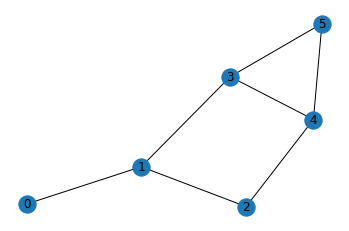

In [6]:
nx.draw_networkx(G)
plt.axis("off")
plt.show()

### Prepare binary variables

In [7]:
N = 6
K = 3
vartype = "BINARY"
q = Array.create("q",shape=[N,K],vartype=vartype)

"q" is name of variables  
shape specifies the shape of variables as vector, matrix, or...  
vartype selects -1 or 1 by "SPIN" and 0 or 1by "BINARY"

In [8]:
print(q)

Array([[Binary(q[0][0]), Binary(q[0][1]), Binary(q[0][2])],
       [Binary(q[1][0]), Binary(q[1][1]), Binary(q[1][2])],
       [Binary(q[2][0]), Binary(q[2][1]), Binary(q[2][2])],
       [Binary(q[3][0]), Binary(q[3][1]), Binary(q[3][2])],
       [Binary(q[4][0]), Binary(q[4][1]), Binary(q[4][2])],
       [Binary(q[5][0]), Binary(q[5][1]), Binary(q[5][2])]])


### Define cost function

In [9]:
E1 = Constraint(np.sum((np.sum(q,axis=1)-1)**2,axis=0),"K")

In [10]:
E2 = 0
for e in edges:
    for k in range(K):
        E2 += q[e[0],k]*q[e[1],k]

In [11]:
Lam = Placeholder('Lam')
E_cost = Lam*E1+E2

### Compile the cost function

In [12]:
model = E_cost.compile()

### Get qubo matrix

In [13]:
feed_dict = {'Lam': 5.0}
Q, offset = model.to_qubo(feed_dict=feed_dict)

### Prepare simulation of quantum annealing

In [14]:
sampler = jij.SQASampler(beta=10.0, gamma=1.0, trotter=4, step_length=10, step_num=10, schedule=None, iteration=1)

This is done by quantum Monte-Carlo simulation  
gamma = strength of quantum fluctuation  
iteration = number of reads  
step_num = number of MCS  
trotter = Trotter number  
step_length = length of MCS in the same gamma   

### Let's simulate quantum annealing

In [15]:
response = sampler.sample_qubo(Q)

### Show results

In [16]:
print(response)

iteration : 1, minimum energy : -30.0, var_type : BINARY
indices: ['q[3][0]', 'q[0][0]', 'q[1][1]', 'q[1][0]', 'q[3][2]', 'q[4][0]', 'q[4][2]', 'q[5][0]', 'q[5][2]', 'q[1][2]', 'q[5][1]', 'q[4][1]', 'q[2][1]', 'q[2][0]', 'q[3][1]', 'q[2][2]', 'q[0][2]', 'q[0][1]'] 
minmum energy state sample : [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]


### minimum sample

In [17]:
response.samples[0]

{'q[3][0]': 0,
 'q[0][0]': 0,
 'q[1][1]': 1,
 'q[1][0]': 0,
 'q[3][2]': 1,
 'q[4][0]': 1,
 'q[4][2]': 0,
 'q[5][0]': 0,
 'q[5][2]': 0,
 'q[1][2]': 0,
 'q[5][1]': 1,
 'q[4][1]': 0,
 'q[2][1]': 0,
 'q[2][0]': 0,
 'q[3][1]': 0,
 'q[2][2]': 1,
 'q[0][2]': 1,
 'q[0][1]': 0}

### decode solution through openJij and pyQUBO

In [18]:
dsol, broken, energy = model.decode_solution(response.samples[0], feed_dict = feed_dict, vartype=vartype)
dsol

{'q': {3: {0: 0, 2: 1, 1: 0},
  0: {0: 0, 2: 1, 1: 0},
  1: {1: 1, 0: 0, 2: 0},
  4: {0: 1, 2: 0, 1: 0},
  5: {0: 0, 2: 0, 1: 1},
  2: {1: 0, 0: 0, 2: 1}}}

In [20]:
def decode_spin2(sol,vartype,feed_dict = None):
    dsol, broken, energy = model.decode_solution(sol, feed_dict = feed_dict, vartype=vartype)
    spin = np.zeros(N)
    for keys1 in dsol["q"]:
        for keys2 in dsol["q"][keys1]:
            if dsol["q"][keys1][keys2]==1:
                spin[keys1] = keys2
    return spin,energy,broken 

We define an original function for decoding the solution from openJij with pyQUBO into a standard expression.  
reposense.min["min_state"] is written on the indices in openJij.
Here we arrange the original order of the variables by our function.

In [21]:
spin,energy,broken = decode_spin2(response.samples[0],vartype=vartype,feed_dict = feed_dict)

### check constraints

In [23]:
print(broken)

{}


### show resulting graph

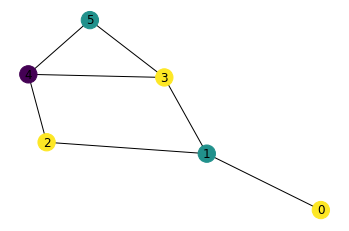

In [24]:
node_colors = [spin[node] for node in G.nodes()]

nx.draw_networkx(G,node_color=node_colors)
plt.axis("off")
plt.show()